<a href="https://colab.research.google.com/github/eduardodut/Analise-tweets-ICD-Unifor/blob/master/AnaliseTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carregamento e leitura dos dados

In [1]:
import pandas as pd
import pickle
#função que realiza o download dos arquivos json
def carregarDados():
  import json
  import pandas as pd

  # Fetch a single <1MB file using the raw GitHub URL.
  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/LulaOficial.json


  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/jairbolsonaro.json     

  #transformação dos arquivos json em datasets
  dataset_lula = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/LulaOficial.json') as lula_file:
    dados = json.load(lula_file)
    dataset_lula = pd.DataFrame(dados)


  dataset_bolso = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/jairbolsonaro.json') as bolso_file:
    dados = json.load(bolso_file)
    dataset_bolso = pd.DataFrame(dados)

  return dataset_bolso, dataset_lula


dataset_bolso, dataset_lula = carregarDados()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.6M  100 47.6M    0     0  32.5M      0  0:00:01  0:00:01 --:--:-- 32.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.9M  100 25.9M    0     0  22.1M      0  0:00:01  0:00:01 --:--:-- 22.2M


In [0]:
def cleaning_data(dataset):

  #realiza cópia do dataset
  dataset_temp = dataset.copy()
  
  #conversão da coluna 'created_at' para formato de data
  dataset_temp['created_at'] = dataset_temp['created_at'].astype('datetime64[ns]')

  #criação da coluna 'caracter_count' a partir da coluna 'display_text_range', que indica o tamanho do tweet
  dataset_temp['character_count'] = [(dataset_temp['display_text_range'][i][1]-dataset_temp['display_text_range'][i][0] + 1)for i in range(0,dataset_temp.shape[0])]

  #função que extrai dados do dicionário da coluna 'user' e transforma em uma coluna do dataset
  def extracao_dados_user(coluna):
    if coluna not in dataset_temp.columns:
      dataset_temp[coluna] = [pd.DataFrame(dataset_temp['user']).loc[i][0].get(coluna) for i in range(0,dataset_temp.shape[0])]

  #função que extrai as hashtags e @ da coluna entities e as coloca em sua própria cluna, em forma de lista
  def extracao_entities():
         
    coluna_hashtags = []
    coluna_user_mentions = []

    for i in range(0,dataset_temp.shape[0]):
      list_hashtags = []
      list_user_mention = []
      if dataset_temp.loc[i]['entities'].get("hashtags") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("hashtags"))):
          list_hashtags.append(dataset_temp.loc[i]['entities'].get("hashtags")[j].get('text'))
      coluna_hashtags.append(list_hashtags)

      if dataset_temp.loc[i]['entities'].get("user_mentions") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("user_mentions"))):
         list_user_mention.append(dataset_temp.loc[i]['entities'].get("user_mentions")[j].get('name'))
      coluna_user_mentions.append(list_user_mention)

    dataset_temp['hashtags'] = coluna_hashtags
    dataset_temp['user_mentions'] = coluna_user_mentions

  extracao_entities()
  #colunas para remoção do dataset
  colunas_para_remocao = ['id_str', 'truncated','index', 'display_text_range', 'entities', 'lang',
                                   'source', 'in_reply_to_status_id','in_reply_to_status_id_str',
                                   'in_reply_to_user_id','in_reply_to_user_id_str', 'in_reply_to_screen_name',
                                   'user','geo','coordinates', 'place', 'contributors', 'is_quote_status',
                                   'possibly_sensitive', 'quoted_status_id','quoted_status_id_str',
                                  'quoted_status_permalink', 'extended_entities', 'quoted_status']
  #remoção das colunas
  dataset_temp = dataset_temp.sort_values('created_at', ascending = True).reset_index().drop(colunas_para_remocao, axis = 1)
  #reindexação do dataframe
  

  
  
  return dataset_temp


#chamada da função de limpeza inicial dos dados
bolso_data = cleaning_data(dataset_bolso)
lula_data = cleaning_data(dataset_lula)

#instanciamento das variaveis que representaram o dataset filtrado por data de cada usuario
bolsonaro_filtrado = bolso_data
lula_filtrado = lula_data

#verificação da data inicial e da data final do período que se tem dados
data_inicial_geral = np.min([bolso_data.loc[0,'created_at'],lula_data.loc[0,'created_at']])
data_final_geral = np.max([bolso_data.loc[bolso_data.shape[0]-1,'created_at'],lula_data.loc[lula_data.shape[0]-1,'created_at']])

#instanciamento do dicionario com datas e eventos relevantes para a análise
dict_datas_relevantes = {data_inicial_geral.strftime('%Y.%m.%d'):"Data inicial do dataset",
                          '2016-08-31':"Fim do processo de impeachment de Dilma",
                          '2017-07-12':'Condenação do lula em 1ª instância',
                          '2018-01-24':'Confirmação da condenação pela 2 instância',
                          '2018-04-07':"Prisão de lula",
                          '2018-07-22':'Confirmação da candidatura do Bolsonaro',
                          '2018-10-07':'1º turno das eleições 2018',
                          '2018-10-28':'2º turno das eleições 2018',
                          '2019-11-08':'Soltura de lula',
                          data_final_geral.strftime('%Y.%m.%d'):"Data final do dataset"}

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')
         

,Data,Evento
0,2010-04-01,Data inicial do dataset
1,2016-08-31,Fim do processo de impeachment de Dilma
2,2017-07-12,Condenação do lula em 1ª instância
3,2018-01-24,Confirmação da condenação pela 2 instância
4,2018-04-07,Prisão de lula
5,2018-07-22,Confirmação da candidatura do Bolsonaro
6,2018-10-07,1º turno das eleições 2018
7,2018-10-28,2º turno das eleições 2018
8,2019-11-08,Soltura de lula
9,2020-01-08,Data final do dataset


In [118]:
#@title Filtro de tempo para as análises e gráficos
#@markdown selecione o período de tempo e o usuário que deverá ter os tweets filtrados

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
Lula = True #@param {type:"boolean"}
Bolsonaro = True #@param {type:"boolean"}

data_inicial_analise = '2017-10-07'  #@param {type: "date"}
data_final_analise = '2019-11-08'  #@param {type: "date"}

dic_datas_analise = {data_inicial_analise:"Data inicial da análise",
                     data_final_analise:"Data final da análise"}

datas_analise = pd.DataFrame(dic_datas_analise.items(), columns=datas_relevantes.columns)
datas_analise['Data'] = datas_analise['Data'].astype('datetime64[ns]')

datas_relevantes = datas_relevantes.append(datas_analise).sort_values("Data")

col_data=[data_inicial_analise, data_final_analise]
datas = pd.DataFrame(col_data, columns=['data'])

datas = datas.data.astype('datetime64[ns]')

if Bolsonaro:
  bolsonaro_filtrado = bolso_data.loc[bolso_data['created_at']>datas[0]]
  bolsonaro_filtrado = bolsonaro_filtrado.loc[bolsonaro_filtrado['created_at']<datas[1]]
else:
  bolsonaro_filtrado = bolso_data

if Lula :
  lula_filtrado = lula_data.loc[lula_data['created_at']>datas[0]]
  lula_filtrado = lula_filtrado.loc[lula_filtrado['created_at']<datas[1]]
else:
  lula_filtrado = lula_data

print("Selecionados ",bolsonaro_filtrado.shape[0]," tweets do Bolsonaro")
print("Selecionados ",lula_filtrado.shape[0]," tweets do lula")

Selecionados  4049  tweets do Bolsonaro
Selecionados  7353  tweets do lula


In [0]:
#linha do tempo
dates = []
names = []
for item in data:
    if 'rc' not in item['tag_name'] and 'b' not in item['tag_name']:
        dates.append(item['published_at'].split("T")[0])
        names.append(item['tag_name'])
# Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]



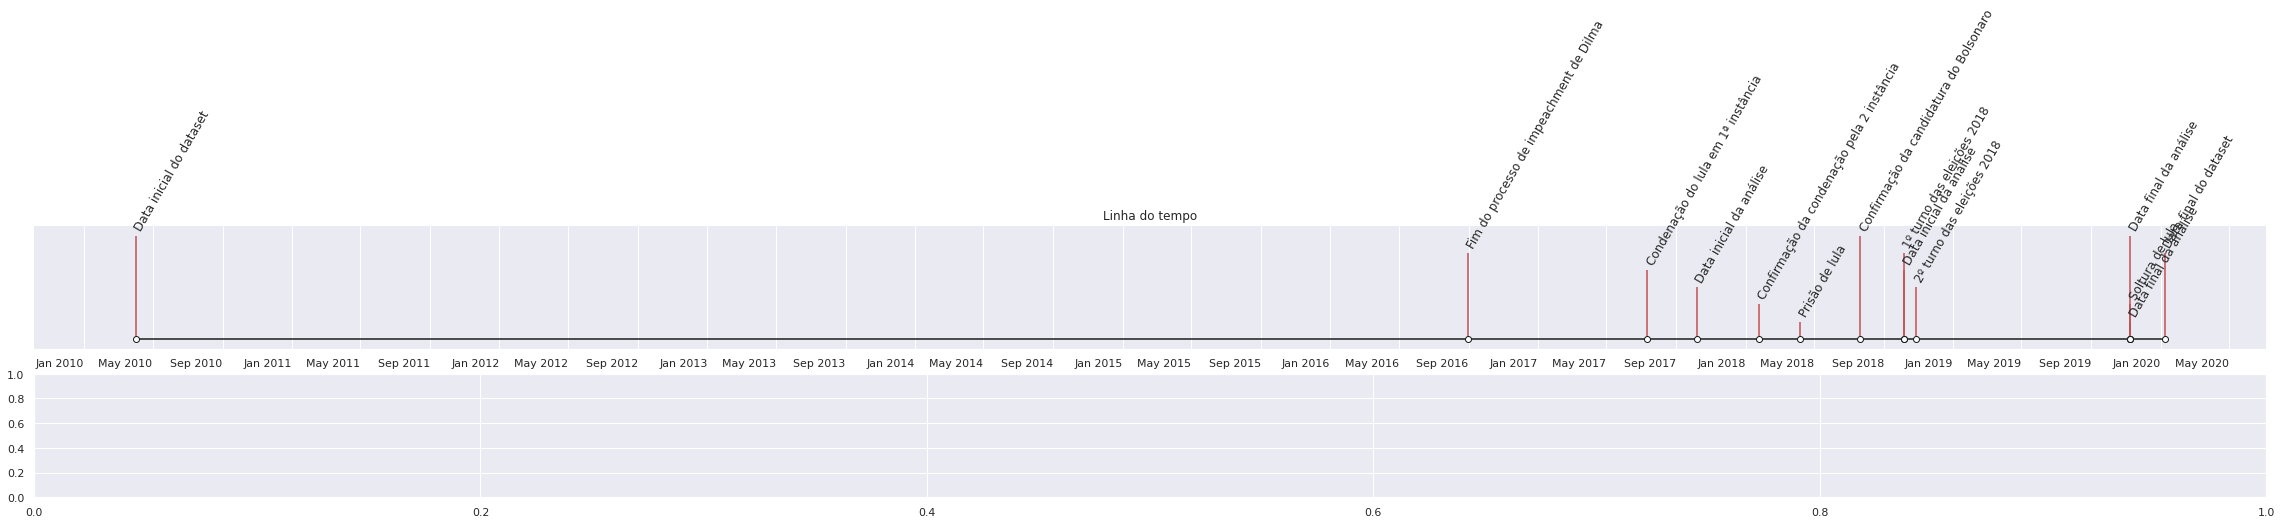

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

eventos = datas_relevantes['Evento']

dates = datas_relevantes['Data']


levels = np.tile([6,5,4,3,2,1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, (ax,ax1) = plt.subplots(2,1)
ax.set(title="Linha do tempo")

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, eventos, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="left", rotation=60)

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

#ax.hist(x=lula_data['created_at'])


ax.margins(y=0.1)
fig.set_size_inches(40,5)
plt.show()

TypeError: ignored

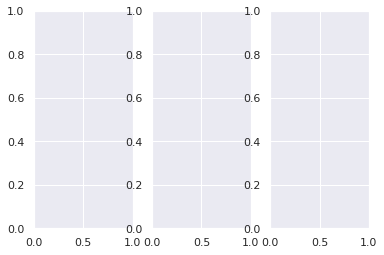

In [49]:
sns.set()
fig, ax = plt.subplots(1,3)

ax[0].bar()

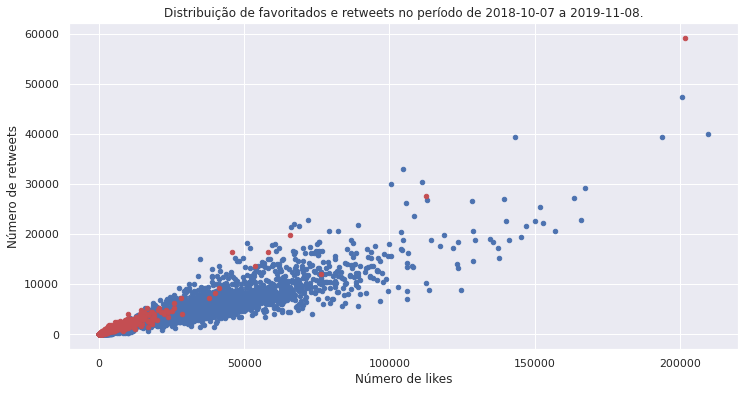

In [24]:
#@title Gráfico 01
#@markdown Visualização em gráfico de dispersão de quantidade de 'retweets' e quantidade de 'favoritado'. Os pontos azuis representam cada tweet de Bolsonaro e os vermelhos representam os tweets de lula

#@markdown Por se tratar de uma variável com alguns outliers é recomendado que se utilize uma escala logaritmica para sua representação. Entretanto ao utilizar a escala logaritmica perde-se o senso da diferença entre as reações aos tweets dos dois usuários. Portanto optou-se por utilizar uma escala linear.

#uso do estilo do seaborn
sns.set()
fig, ax = plt.subplots()

ax.scatter(x= bolsonaro_filtrado['favorite_count'], y= bolsonaro_filtrado['retweet_count'], color = 'b',s=20)
ax.scatter(x= lula_filtrado['favorite_count'], y= lula_filtrado['retweet_count'],  color = 'r',s=20)
# Set the x-axis label
ax.set_xlabel("Número de likes")

# Set the y-axis label
ax.set_ylabel("Número de retweets")

ax.set_title(''.join(["Distribuição de favoritados e retweets no período de ", data_inicial," a ", data_final,"."]))


fig.set_size_inches(12,6)

plt.show()

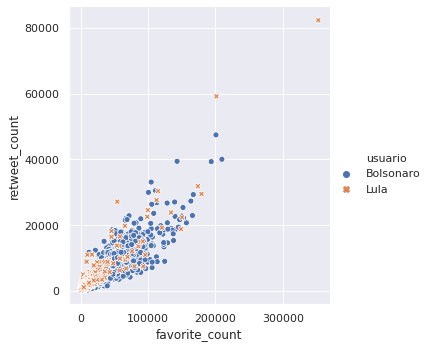

In [14]:
# fig,ax=plt.subplots()
# ax.set(xscale="log", yscale="log")
# ax.set(title=titulo)
concatenated = pd.concat([bolsonaro_filtrado.assign(usuario='Bolsonaro'), lula_filtrado.assign(usuario='Lula')])
titulo = "Distribuição de retweets e favoritados entre ",data_inicial," e ",data_final
sns.relplot(x='favorite_count', y='retweet_count', data= concatenated, hue= 'usuario', style='usuario' )




# ax.set_titles(('Distribuição de retweests e favoritados entre ',data_inicial,' e ',data_final))

# sns.relplot(x='favorite_count', y= 'retweet_count', data = lula_filtrado)

# ax.scatter(x= lula_filtrado['favorite_count'], y= lula_filtrado['retweet_count'],  color = 'r',s=1)
# # Set the x-axis label
# ax.set_xlabel("Número de likes")

# # Set the y-axis label
# ax.set_ylabel("Número de retweets")

# ax.set_title("Distribuição de likes e retweets")

# fig.set_size_inches(12,12)

# plt.show()

In [0]:
sns.barplot(data=df,
         y='Award_Amount',
         x='Model Selected',
         hue='Region')

plt.show()
plt.clf()

barplot

In [0]:
from statsmodels.stats.weightstats import ztest
import math

curtidas_retweets_bolso = bolso_data.favorite_count+bolso_data.retweet_count
curtidas_retweets_lula = lula_data.favorite_count+lula_data.retweet_count

n_lula = curtidas_retweets_lula.describe()[0]
n_bolso = curtidas_retweets_bolso.describe()[0]

media_lula = curtidas_retweets_lula.describe()[1]
media_bolso = curtidas_retweets_bolso.describe()[1]

sd_lula = curtidas_retweets_lula.describe()[2]
sd_bolso = curtidas_retweets_bolso.describe()[2] 

pooled_variance = (sd_lula/n_lula + sd_bolso/n_bolso)**(1/2)

z = (media_bolso-media_lula)/pooled_variance

# z = ztest(curtidas_retweets_bolso,curtidas_retweets_lula)
print(z)

8910.481301603764


In [138]:

import re
import string
from nltk.corpus import stopwords as sw
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
def limpar_combinar_texto(dataset):
    
    nltk.download("stopwords")  
    
    stopwords = sw.words('portuguese')#+ list(punctuation))
    #lista_tweets = ''dataset.full_text
    '''Takes a list of text and combines them into one large chunk of text.'''
    lista_tweets = []
    for tweet in dataset.full_text:
      tweet = re.sub('^https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
      tweet = re.sub('\[.,!*?\]', '', tweet)
      
      tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
      tweet = re.sub('\w*\d\w*', '', tweet)
  
      tweet = re.sub('[‘’“”…]', '', tweet)
      tweet = re.sub('\n', '', tweet)
      tweet = tweet.lower()
      lista_tweets.append(tweet)
     # Substituting multiple spaces with single space
    #lista_tweets= re.sub(r'\s+', ' ', lista_tweets, flags=re.I)
    #tknzr = TweetTokenizer()
    #alltokens = tknzr.tokenize(lista_tweets)
      #lista_tweets = ' '.join([w for w in alltokens if not w in stopwords])
 
    return lista_tweets

texto_lula = limpar_combinar_texto(lula_data)
texto_bolso = limpar_combinar_texto(bolso_data)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer  

def lista_top_words(lista_tweets):
  tfidfconverter = TfidfVectorizer(ngram_range= (1,1), stop_words=sw.words('portuguese'))  
  X = tfidfconverter.fit_transform(lista_tweets)

  tfidf_bolso = pd.DataFrame(X.toarray(), columns= tfidfconverter.get_feature_names())

  return pd.DataFrame(tfidf_bolso.sum().sort_values(ascending = False))

top_words_bolso = lista_top_words(texto_bolso)
top_words_lula = lista_top_words(texto_lula)

In [0]:
print(top_words_bolso.head())
print(top_words_lula.head())

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,2))
data_cv = cv.fit_transform(' '.join([w for w in texto_bolso ]))
data_dtm = pd.DataFrame([data_cv.toarray()], columns=cv.get_feature_names())

data_dtm.transpose().sort_values(0, ascending= False)[:20]

ValueError: ignored

In [0]:
cv = CountVectorizer(ngram_range=(1,1))
data_cv = cv.fit_transform([texto_lula])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

data_dtm.transpose().sort_values(0, ascending= False)[:20]

NameError: ignored

In [0]:
texto_lula.toarray()[0][2]

1

In [0]:
# Import the necessary modules




TypeError: ignored

In [0]:
alltokens

['lula',
 'acaba',
 'de',
 'chegar',
 'ao',
 'smabc',
 'de',
 'onde',
 'começará',
 'caminhada',
 'junto',
 'com',
 'dilmabr',
 'lulaedilmanoabc',
 'acompanhe',
 'notícias',
 'da',
 'caminhada',
 'também',
 'pelo',
 'ptbrasil',
 'e',
 'mudamais',
 'lulaedilmanoabc',
 'lula',
 'visita',
 'o',
 'smabc',
 'e',
 'cumprimenta',
 'sindicalistas',
 'e',
 'funcionários',
 'ao',
 'lado',
 'de',
 'dilmabr',
 'lulaedilmanoabc',
 'dilmabr',
 'e',
 'lula',
 'saem',
 'agora',
 'pelas',
 'ruas',
 'de',
 'são',
 'bernardo',
 'do',
 'campo',
 'e',
 'são',
 'saudados',
 'pela',
 'população',
 'lulaedilmanoabc',
 'os',
 'trabalhadores',
 'estão',
 'com',
 'dilmabr',
 'diz',
 'o',
 'prefeito',
 'de',
 'são',
 'bernardo',
 'do',
 'campo',
 'luiz',
 'marinho',
 'marinhopt',
 'à',
 'população',
 'lulaedilmanoabc',
 'mais',
 'de',
 'mil',
 'pessoas',
 'acompanham',
 'dilmabr',
 'e',
 'lula',
 'pelas',
 'ruas',
 'de',
 'são',
 'bernardo',
 'lulaedilmanoabc',
 'vocês',
 'geraram',
 'milhões',
 'de',
 'empregos'